In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from PIL import Image, ImageEnhance
from sklearn.decomposition import PCA
from zipfile import ZipFile
from google.colab import files
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
unzip_dir = "/content/unzipped_audio"
with zipfile.ZipFile("/content/drive/My Drive/audio.zip", 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

audio_dir = os.path.join(unzip_dir, "audio")
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.mp3')]

In [8]:
# 2. Basic EDA
!pip install pydub
from pydub import AudioSegment
audio_durations = [AudioSegment.from_mp3(os.path.join(audio_dir, f)).duration_seconds for f in audio_files]


In [9]:
# Listing the files inside the "audio" directory
audio_dir = os.path.join(unzip_dir, 'audio')
audio_files = [f for f in os.listdir(audio_dir) if os.path.isfile(os.path.join(audio_dir, f))]

# Getting file extensions and their counts
file_extensions = [os.path.splitext(file)[1] for file in audio_files]
extension_counts = {ext: file_extensions.count(ext) for ext in set(file_extensions)}

audio_files[:10], extension_counts  # Displaying the first 10 audio files and the file extension counts

(['14.mp3',
  '9.mp3',
  '5.mp3',
  '19.mp3',
  '11.mp3',
  '7.mp3',
  '1.mp3',
  '0.mp3',
  '12.mp3',
  '6.mp3'],
 {'.mp3': 20})

In [11]:
!pip install mutagen
from mutagen.mp3 import MP3

# Calculating the durations using mutagen
durations_mutagen = []
for file in audio_files:
    file_path = os.path.join(audio_dir, file)
    audio = MP3(file_path)
    durations_mutagen.append(audio.info.length)

# Getting a basic summary of the durations using mutagen
min_duration_mutagen = min(durations_mutagen)
max_duration_mutagen = max(durations_mutagen)
avg_duration_mutagen = sum(durations_mutagen) / len(durations_mutagen)

min_duration_mutagen, max_duration_mutagen, avg_duration_mutagen


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.1 MB/s eta 0:00:00


(2.899591836734694, 7.248979591836735, 4.011102040816326)

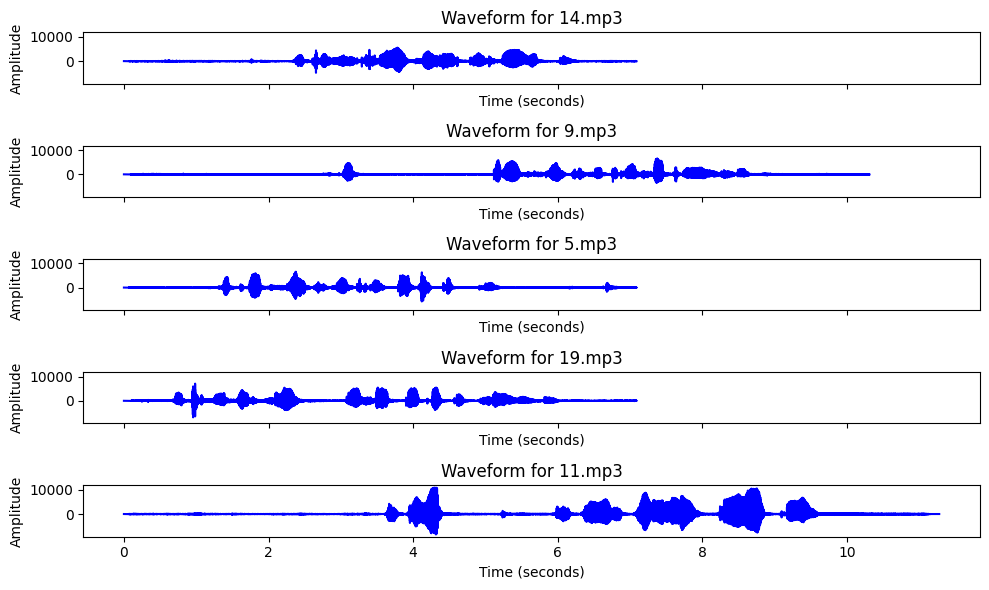

In [13]:
from pydub import AudioSegment

# Define your subset here (for example, the first 5 files)
subset_files = audio_files[:5]

# Function to visualize audio waveform using pydub and numpy
def plot_waveform_pydub(file_path, ax, title):
    audio = AudioSegment.from_mp3(file_path)
    samples = np.array(audio.get_array_of_samples())

    # Create a time axis in seconds
    times = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))

    ax.plot(times, samples, color='b')
    ax.set_title(title)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')

fig, axs = plt.subplots(nrows=len(subset_files), ncols=1, figsize=(10, 6), sharex=True, sharey=True)

for i, file in enumerate(subset_files):
    file_path = os.path.join(audio_dir, file)
    plot_waveform_pydub(file_path, axs[i], f"Waveform for {file}")

plt.tight_layout()
plt.show()



<ipython-input-15-38f89c78432a>:10: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
<ipython-input-15-38f89c78432a>:10: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
<ipython-input-15-38f89c78432a>:10: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
<ipython-input-15-38f89c78432a>:10: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
<ipython-input-15-38f89c78432a>:10: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')


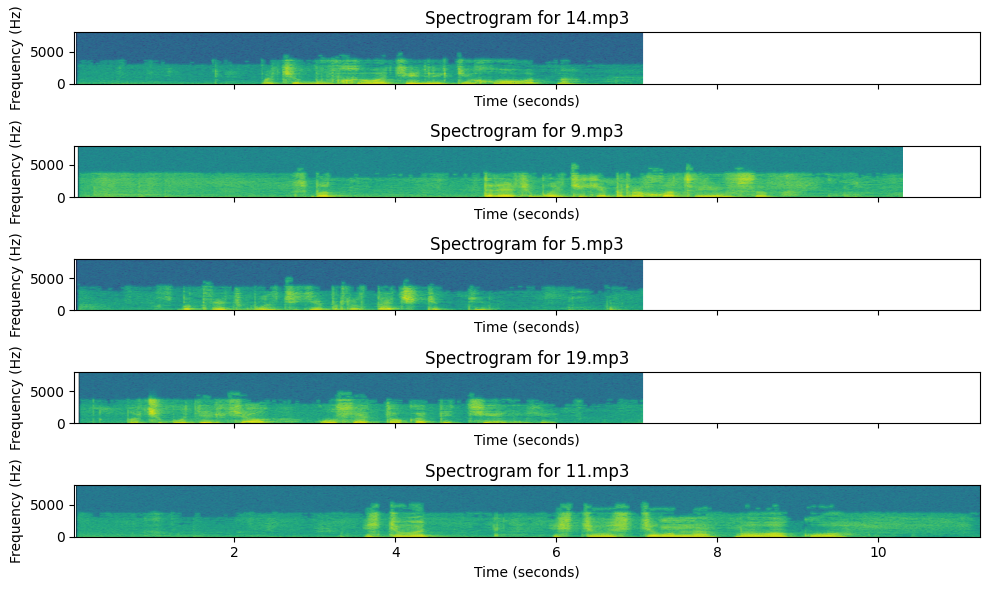

In [15]:
from scipy.signal import spectrogram
from pydub import AudioSegment

# Define your subset here (for example, the first 5 files)
subset_files = audio_files[:5]

# Function to visualize audio spectrogram
def plot_spectrogram(samples, sample_rate, ax, title):
    frequencies, times, Sxx = spectrogram(samples, fs=sample_rate, nperseg=1024, noverlap=512)
    ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_title(title)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_ylim(0, 8000)  # Limit frequency range for better visualization

fig, axs = plt.subplots(nrows=len(subset_files), ncols=1, figsize=(10, 6), sharex=True, sharey=True)

for i, file in enumerate(subset_files):
    file_path = os.path.join(audio_dir, file)
    audio = AudioSegment.from_mp3(file_path)
    samples = np.array(audio.get_array_of_samples())
    plot_spectrogram(samples, audio.frame_rate, axs[i], f"Spectrogram for {file}")

plt.tight_layout()
plt.show()



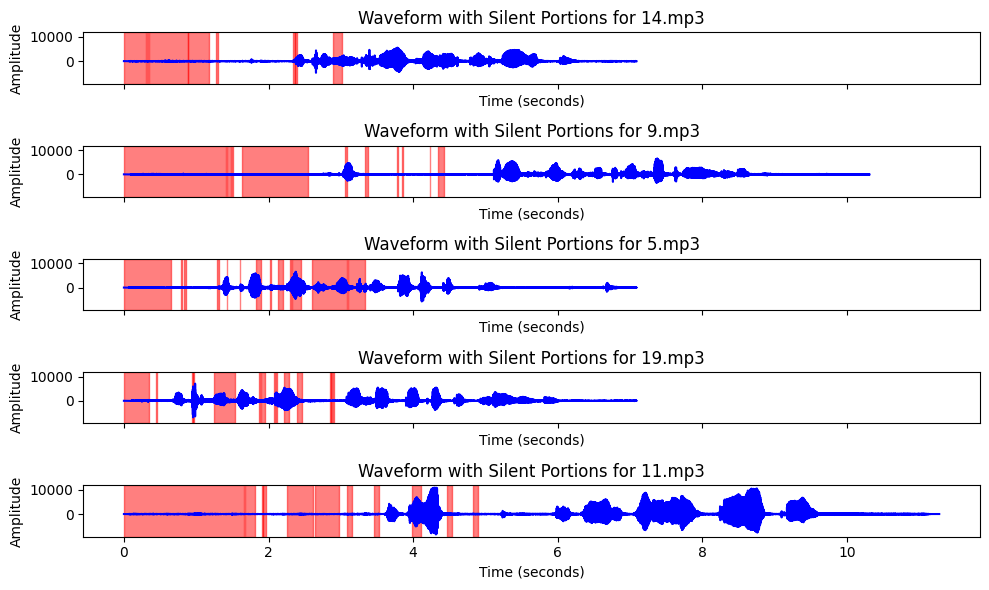

In [17]:
from pydub import AudioSegment

# Define your subset here (for example, the first 5 files)
subset_files = audio_files[:5]

# Function to identify silent portions in audio
def detect_silence(audio, silence_threshold=-50.0, chunk_size=10):
    """
    Detect silent chunks in an AudioSegment instance.
    Returns a list of [start, end] for silent portions.
    """
    silent_chunks = []
    start_time = None
    for t in range(0, len(audio), chunk_size):
        chunk = audio[t:t+chunk_size]
        if chunk.dBFS < silence_threshold and start_time is None:
            start_time = t
        if chunk.dBFS >= silence_threshold and start_time is not None:
            end_time = t
            silent_chunks.append([start_time, end_time])
            start_time = None
    return silent_chunks

# Detecting silent portions in selected audio files and visualizing them
fig, axs = plt.subplots(nrows=len(subset_files), ncols=1, figsize=(10, 6), sharex=True, sharey=True)

for i, file in enumerate(subset_files):
    file_path = os.path.join(audio_dir, file)
    audio = AudioSegment.from_mp3(file_path)
    samples = np.array(audio.get_array_of_samples())

    # Detect silent portions
    silent_chunks = detect_silence(audio)

    # Create a time axis in seconds
    times = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))

    axs[i].plot(times, samples, color='b')
    for chunk in silent_chunks:
        axs[i].axvspan(chunk[0] / 1000, chunk[1] / 1000, color='red', alpha=0.5)
    axs[i].set_title(f"Waveform with Silent Portions for {file}")
    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [19]:
from pydub import AudioSegment

# Function to normalize audio to a target dBFS
def normalize_audio(audio, target_dBFS=-20.0):
    change_in_dBFS = target_dBFS - audio.dBFS
    return audio.apply_gain(change_in_dBFS)

# Define your audio directory and the subset you want to process
audio_dir = "/content/unzipped_audio/audio"
subset_files = audio_files[:5]

normalized_audio_dir = "/content/unzipped_audio/normalized_audio"
os.makedirs(normalized_audio_dir, exist_ok=True)

for file in subset_files:
    file_path = os.path.join(audio_dir, file)
    audio = AudioSegment.from_mp3(file_path)

    normalized_audio = normalize_audio(audio)
    normalized_file_path = os.path.join(normalized_audio_dir, file)
    normalized_audio.export(normalized_file_path, format="mp3")

# Listing the normalized audio files from the subset
subset_normalized_files = [file for file in os.listdir(normalized_audio_dir) if file in subset_files]
subset_normalized_files



['14.mp3', '9.mp3', '5.mp3', '19.mp3', '11.mp3']

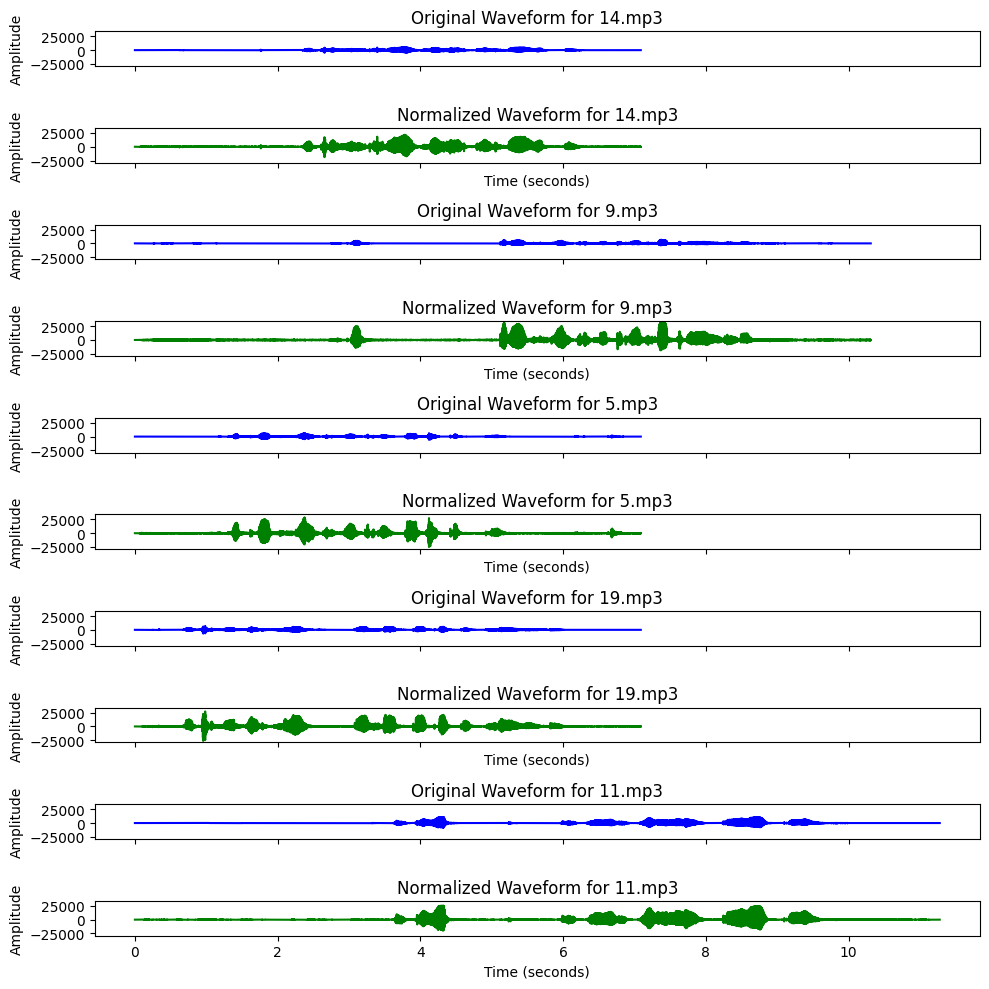

In [20]:
# Function to visualize audio waveform using pydub and numpy
def plot_waveform_comparison(original_file, normalized_file, axs, title):
    # Load original audio
    original_audio = AudioSegment.from_mp3(original_file)
    original_samples = np.array(original_audio.get_array_of_samples())
    original_times = np.linspace(0, len(original_samples) / original_audio.frame_rate, num=len(original_samples))

    # Load normalized audio
    normalized_audio = AudioSegment.from_mp3(normalized_file)
    normalized_samples = np.array(normalized_audio.get_array_of_samples())
    normalized_times = np.linspace(0, len(normalized_samples) / normalized_audio.frame_rate, num=len(normalized_samples))

    # Plotting
    axs[0].plot(original_times, original_samples, color='b')
    axs[0].set_title(f"Original Waveform for {title}")
    axs[0].set_ylabel('Amplitude')

    axs[1].plot(normalized_times, normalized_samples, color='g')
    axs[1].set_title(f"Normalized Waveform for {title}")
    axs[1].set_xlabel('Time (seconds)')
    axs[1].set_ylabel('Amplitude')

fig, axs = plt.subplots(nrows=2*len(subset_files), ncols=1, figsize=(10, 2*len(subset_files)), sharex=True, sharey=True)

for i, file in enumerate(subset_files):
    original_file_path = os.path.join(audio_dir, file)
    normalized_file_path = os.path.join(normalized_audio_dir, file)
    plot_waveform_comparison(original_file_path, normalized_file_path, [axs[2*i], axs[2*i+1]], file)

plt.tight_layout()
plt.show()


In [21]:
# Target sample rate for resampling
TARGET_SAMPLE_RATE = 16000

# Directory to save resampled audio files
resampled_audio_dir = os.path.join(unzip_dir, 'resampled_audio')
os.makedirs(resampled_audio_dir, exist_ok=True)

# Resampling the subset of audio files and saving them
for file in subset_files:
    file_path = os.path.join(normalized_audio_dir, file)  # Using normalized files as input
    audio = AudioSegment.from_mp3(file_path)

    resampled_audio = audio.set_frame_rate(TARGET_SAMPLE_RATE)
    resampled_file_path = os.path.join(resampled_audio_dir, file)
    resampled_audio.export(resampled_file_path, format="mp3")

# Listing the resampled audio files from the subset
subset_resampled_files = [file for file in os.listdir(resampled_audio_dir) if file in subset_files]
subset_resampled_files


['14.mp3', '9.mp3', '5.mp3', '19.mp3', '11.mp3']

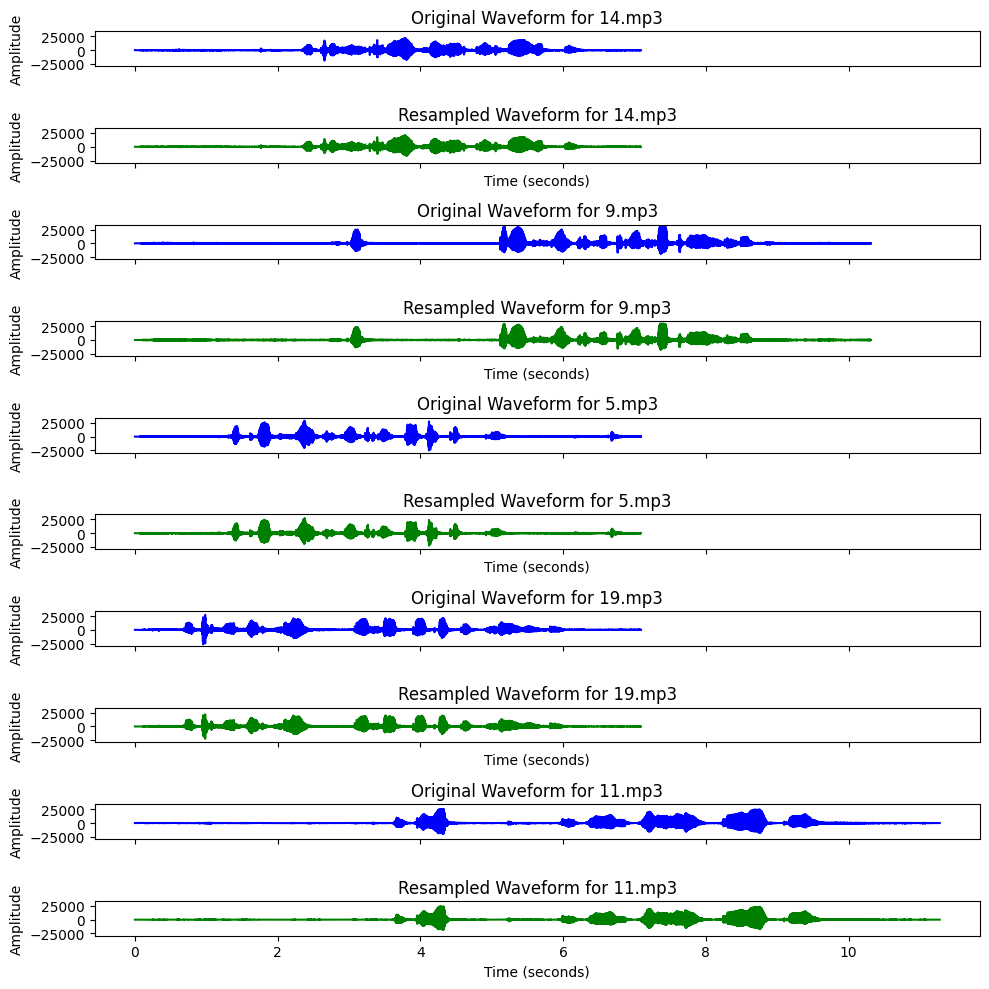

In [22]:
# Function to visualize audio waveform comparison between original and resampled audio
def plot_resampled_comparison(original_file, resampled_file, axs, title):
    # Load original audio
    original_audio = AudioSegment.from_mp3(original_file)
    original_samples = np.array(original_audio.get_array_of_samples())
    original_times = np.linspace(0, len(original_samples) / original_audio.frame_rate, num=len(original_samples))

    # Load resampled audio
    resampled_audio = AudioSegment.from_mp3(resampled_file)
    resampled_samples = np.array(resampled_audio.get_array_of_samples())
    resampled_times = np.linspace(0, len(resampled_samples) / resampled_audio.frame_rate, num=len(resampled_samples))

    # Plotting
    axs[0].plot(original_times, original_samples, color='b')
    axs[0].set_title(f"Original Waveform for {title}")
    axs[0].set_ylabel('Amplitude')

    axs[1].plot(resampled_times, resampled_samples, color='g')
    axs[1].set_title(f"Resampled Waveform for {title}")
    axs[1].set_xlabel('Time (seconds)')
    axs[1].set_ylabel('Amplitude')

fig, axs = plt.subplots(nrows=2*len(subset_files), ncols=1, figsize=(10, 2*len(subset_files)), sharex=True, sharey=True)

for i, file in enumerate(subset_files):
    original_file_path = os.path.join(normalized_audio_dir, file)  # Using normalized files as original
    resampled_file_path = os.path.join(resampled_audio_dir, file)
    plot_resampled_comparison(original_file_path, resampled_file_path, [axs[2*i], axs[2*i+1]], file)

plt.tight_layout()
plt.show()


In [23]:
# Function to extract basic amplitude features using pydub and numpy
def extract_basic_features(file_path):
    audio = AudioSegment.from_mp3(file_path)
    samples = np.array(audio.get_array_of_samples())

    mean_amplitude = np.mean(samples)
    std_amplitude = np.std(samples)
    max_amplitude = np.max(samples)
    min_amplitude = np.min(samples)

    return mean_amplitude, std_amplitude, max_amplitude, min_amplitude

# Extracting basic features for the subset of resampled audio files
basic_features = {}
for file in subset_resampled_files:
    file_path = os.path.join(resampled_audio_dir, file)
    features = extract_basic_features(file_path)
    basic_features[file] = features

# Displaying the basic features for the first audio file
subset_resampled_files[0], basic_features[subset_resampled_files[0]]


('14.mp3', (-21.80799957674197, 2955.5049678325117, 20607, -16380))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


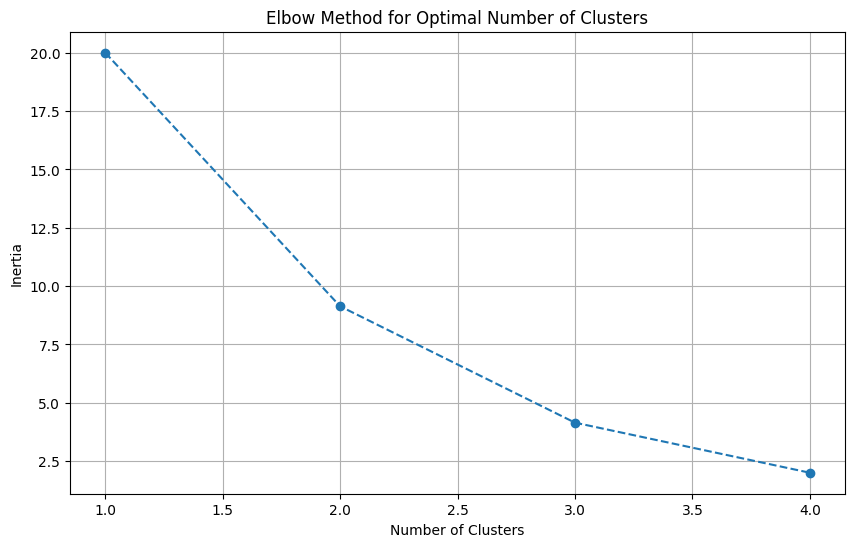

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extracting features for clustering
feature_matrix = np.array(list(basic_features.values()))

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# Finding the optimal number of clusters using the Elbow method
inertia_values = []
possible_clusters = range(1, min(10, len(scaled_features)))

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow method results
plt.figure(figsize=(10, 6))
plt.plot(possible_clusters, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


In [25]:
# Function to perform K-Means clustering and visualize results
def perform_kmeans_clustering(n_clusters, features, file_names):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)

    # Mapping file names to cluster labels
    file_cluster_map = dict(zip(file_names, cluster_labels))

    return file_cluster_map

# Clustering into 2 clusters
clusters_2 = perform_kmeans_clustering(2, scaled_features, subset_resampled_files)

# Clustering into 3 clusters
clusters_3 = perform_kmeans_clustering(3, scaled_features, subset_resampled_files)

clusters_2, clusters_3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({'14.mp3': 1, '9.mp3': 0, '5.mp3': 0, '19.mp3': 0, '11.mp3': 1},
 {'14.mp3': 1, '9.mp3': 2, '5.mp3': 0, '19.mp3': 0, '11.mp3': 1})

In [26]:
from sklearn.ensemble import IsolationForest

# Applying Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.2, random_state=42)
anomalies = iso_forest.fit_predict(scaled_features)

# Mapping file names to anomaly labels
# Note: -1 indicates an anomaly, and 1 indicates a normal observation
file_anomaly_map = dict(zip(subset_resampled_files, anomalies))

file_anomaly_map


{'14.mp3': 1, '9.mp3': -1, '5.mp3': 1, '19.mp3': 1, '11.mp3': 1}